In [1]:
import pandas as pd
import numpy as np
import random
import missingno as msno

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Introduction of the dataset

The dataset that I have chosen from kaggle can be found at the link https://www.kaggle.com/datasets/bwandowando/clash-royale-season-18-dec-0320-dataset, In particular I have used the first csv file, which is the one containing 2,823,527 Season 18 ladder matches of January 2021 (*"battlesStaging_01012021_WL_tagged.csv"*).

In this notebook I will do a first rough preprocessing, because the dataset on kaggle is rich of a lot of columns that are not useful to us. In addition the two players are represented as "winner" and "loser", instead I will call them "p0" for the first player, "p1" for the second player and add the column "winner" which will indicate the winner of the match. This "winner" column that contain binary values is fundamental for our task of binary classification.

In [2]:
df = pd.read_csv('./data/battlesStaging_01012021_WL_tagged.csv', index_col=0)
df.shape

(2823527, 73)

In [3]:
print(df.columns.tolist())

['battleTime', 'arena.id', 'gameMode.id', 'average.startingTrophies', 'winner.tag', 'winner.startingTrophies', 'winner.trophyChange', 'winner.crowns', 'winner.kingTowerHitPoints', 'winner.princessTowersHitPoints', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.startingTrophies', 'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints', 'loser.clan.tag', 'loser.clan.badgeId', 'loser.princessTowersHitPoints', 'tournamentTag', 'winner.card1.id', 'winner.card1.level', 'winner.card2.id', 'winner.card2.level', 'winner.card3.id', 'winner.card3.level', 'winner.card4.id', 'winner.card4.level', 'winner.card5.id', 'winner.card5.level', 'winner.card6.id', 'winner.card6.level', 'winner.card7.id', 'winner.card7.level', 'winner.card8.id', 'winner.card8.level', 'winner.cards.list', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 'winner.elixi

General statistics of the match: 'battleTime', 'arena.id', 'gameMode.id', 'tournamentTag', 'average.startingTrophies'.

Statistics about the players, for both the winner and the loser (from each one of the wollowing we have two copies, one with the prefix 'winner' and one with the prefix loser, ex: winner.tag, loser.tag):<br>
'tag', 'startingTrophies', 'trophyChange', 'crowns', 'kingTowerHitPoints', 'princessTowersHitPoints', 'clan.tag', 'clan.badgeId',<br>
'card1.id', 'card1.level', 'card2.id', 'card2.level', 'card3.id', 'card3.level', 'card4.id', 'card4.level', 'card5.id', 'card5.level', 'card6.id', 'card6.level', 'card7.id', 'card7.level', 'card8.id', 'card8.level',<br>
'cards.list', 'totalcard.level', 'troop.count', 'structure.count', 'spell.count', 'common.count', 'rare.count', 'epic.count', 'legendary.count', 'elixir.average', 

## Drop columns

I do a first skimming of the columns.


```python
columns_to_drop = [
    # This columns must be removed since they imply who is the winner of the match (given their meaning in the game)
    'winner.trophyChange', 'winner.crowns', 'winner.kingTowerHitPoints', 'winner.princessTowersHitPoints',
    'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints', 'loser.princessTowersHitPoints',
    
    # Not important
    'winner.cards.list', 'loser.cards.list', 'battleTime',

    # We can keep simply the total card level
    'winner.card1.level', 'winner.card2.level', 'winner.card3.level', 'winner.card4.level', 
    'winner.card5.level', 'winner.card6.level', 'winner.card7.level', 'winner.card8.level',
    'loser.card1.level', 'loser.card2.level', 'loser.card3.level', 'loser.card4.level', 
    'loser.card5.level', 'loser.card6.level', 'loser.card7.level', 'loser.card8.level'
]
```

I remove the level of the single cards not just for occupying less memory and because it isn't very important (since we have the total card level), but also because I will encode in a different way the cards in the deck. I will have a column for each card (x2 since I have two players) and we put 1 if the card is present and 0 otherwise. It is important because the deck is just a set, the index/position of the cards is not important. For this reason I can't have the level specified for each card, since I will not have a card1, card2... column.

In [4]:
columns_to_drop = [
    'winner.trophyChange', 'winner.crowns', 'winner.kingTowerHitPoints', 'winner.princessTowersHitPoints',
    'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints', 'loser.princessTowersHitPoints',
    'winner.cards.list', 'loser.cards.list', 'battleTime',
    'winner.card1.level', 'winner.card2.level', 'winner.card3.level', 'winner.card4.level', 
    'winner.card5.level', 'winner.card6.level', 'winner.card7.level', 'winner.card8.level',
    'loser.card1.level', 'loser.card2.level', 'loser.card3.level', 'loser.card4.level', 
    'loser.card5.level', 'loser.card6.level', 'loser.card7.level', 'loser.card8.level'
]
df.drop(columns_to_drop, axis=1, inplace=True)
df.shape

(2823527, 46)

I will keep only the main game mode, because in the dataset isn't specified the meaning of this column

In [5]:
df['gameMode.id'].value_counts()

gameMode.id
72000201.0    1815549
72000006.0    1007867
72000023.0        111
Name: count, dtype: int64

In [6]:
# We keep only the main game mode and we eliminate the gameMode.id column
df = df.loc[df['gameMode.id'] == df['gameMode.id'].mode()[0]].drop(['gameMode.id'], axis=1)
df.shape

(1815549, 45)

## Encoding of the two players

Encode "winner" and "loser" as "p0" and "p1".<br>
To do our classification task I can't maintain the "winner" and "loser" prefixes, I will rename the columns with player0 and player1, then I will add a column which indicates who is the winner of the match: 0 if player0 is the winner, 1 if player1 is the winner.

I will do in this way:
- shuffle the rows of the dataframe;
- split the dataframe in two halves and rename the columns:
    - in the first half I will rename the "winner" as "p0" and the "loser" as "p1";
    - add the column "winner" full of 0;
    - in the second half I will rename the "winner" as "p1" and the "loser" as "p0";
    - add the column "winner" full of 1;
- reorder the columns;
- concatenate back together the two dataframes;

In [7]:
print(df.columns.tolist())

['arena.id', 'average.startingTrophies', 'winner.tag', 'winner.startingTrophies', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.startingTrophies', 'loser.clan.tag', 'loser.clan.badgeId', 'tournamentTag', 'winner.card1.id', 'winner.card2.id', 'winner.card3.id', 'winner.card4.id', 'winner.card5.id', 'winner.card6.id', 'winner.card7.id', 'winner.card8.id', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 'winner.elixir.average', 'loser.card1.id', 'loser.card2.id', 'loser.card3.id', 'loser.card4.id', 'loser.card5.id', 'loser.card6.id', 'loser.card7.id', 'loser.card8.id', 'loser.totalcard.level', 'loser.troop.count', 'loser.structure.count', 'loser.spell.count', 'loser.common.count', 'loser.rare.count', 'loser.epic.count', 'loser.legendary.count', 'loser.elixir.average']


**My starting list of columns:**

```python
['winner.tag', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.clan.tag', 'loser.clan.badgeId', 'tournamentTag', 

'arena.id', 'average.startingTrophies', 'winner.startingTrophies', 'loser.startingTrophies',

'winner.card1.id', 'winner.card2.id', 'winner.card3.id', 'winner.card4.id', 'winner.card5.id', 'winner.card6.id', 'winner.card7.id', 'winner.card8.id', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 'winner.elixir.average', 

'loser.card1.id', 'loser.card2.id', 'loser.card3.id', 'loser.card4.id', 'loser.card5.id', 'loser.card6.id', 'loser.card7.id', 'loser.card8.id', 'loser.totalcard.level', 'loser.troop.count', 'loser.structure.count', 'loser.spell.count', 'loser.common.count', 'loser.rare.count', 'loser.epic.count', 'loser.legendary.count', 'loser.elixir.average']
```

In [8]:
# shuffle the rows of the dataframe
df = df.sample(frac=1).reset_index(drop=True)   
# while I rename the players, I would also change the dot "." with "_"
df.rename(columns={'arena.id': 'arena_id', 'average.startingTrophies': 'average_startingTrophies'}, inplace=True)

# Split the DataFrame
mid = len(df) // 2
df0 = df.iloc[:mid]
df1 = df.iloc[mid:]


# df0 -> the winner is player0
    # "winner" -> p0
    # "loser"  -> p1
columns_dict_df0 = {
    'winner.tag':'p0_tag', 'winner.clan.tag':'p0_clan_tag', 'winner.clan.badgeId':'p0_clan_badgeId',
    'loser.tag' :'p1_tag', 'loser.clan.tag' :'p1_clan_tag', 'loser.clan.badgeId' :'p1_clan_badgeId',

    'winner.startingTrophies':'p0_startingTrophies', 'loser.startingTrophies':'p1_startingTrophies',

    'winner.card1.id':'p0_card1_id', 'winner.card2.id':'p0_card2_id', 'winner.card3.id':'p0_card3_id', 
    'winner.card4.id':'p0_card4_id', 'winner.card5.id':'p0_card5_id', 'winner.card6.id':'p0_card6_id', 
    'winner.card7.id':'p0_card7_id', 'winner.card8.id':'p0_card8_id', 
    'winner.totalcard.level':'p0_totalcard_level', 'winner.troop.count':'p0_troop_count', 'winner.structure.count':'p0_structure_count', 
    'winner.spell.count':'p0_spell_count', 'winner.common.count':'p0_common_count', 'winner.rare.count':'p0_rare_count', 
    'winner.epic.count':'p0_epic_count', 'winner.legendary.count':'p0_legendary_count', 'winner.elixir.average':'p0_elixir_average', 

    'loser.card1.id':'p1_card1_id', 'loser.card2.id':'p1_card2_id', 'loser.card3.id':'p1_card3_id', 
    'loser.card4.id':'p1_card4_id', 'loser.card5.id':'p1_card5_id', 'loser.card6.id':'p1_card6_id', 
    'loser.card7.id':'p1_card7_id', 'loser.card8.id':'p1_card8_id', 
    'loser.totalcard.level':'p1_totalcard_level', 'loser.troop.count':'p1_troop_count', 'loser.structure.count':'p1_structure_count', 
    'loser.spell.count':'p1_spell_count', 'loser.common.count':'p1_common_count', 'loser.rare.count':'p1_rare_count', 
    'loser.epic.count':'p1_epic_count', 'loser.legendary.count':'p1_legendary_count', 'loser.elixir.average':'p1_elixir_average',
}

df0.rename(columns=columns_dict_df0, inplace=True)
df0['winner'] = 0 # the winner is player0


# df1 -> the winner is player1
    # "winner" -> p1
    # "loser"  -> p0
columns_dict_df1 = {
    'winner.tag':'p1_tag', 'winner.clan.tag':'p1_clan_tag', 'winner.clan.badgeId':'p1_clan_badgeId',
    'loser.tag' :'p0_tag', 'loser.clan.tag' :'p0_clan_tag', 'loser.clan.badgeId' :'p0_clan_badgeId',

    'winner.startingTrophies':'p1_startingTrophies', 'loser.startingTrophies':'p0_startingTrophies',

    'winner.card1.id':'p1_card1_id', 'winner.card2.id':'p1_card2_id', 'winner.card3.id':'p1_card3_id', 
    'winner.card4.id':'p1_card4_id', 'winner.card5.id':'p1_card5_id', 'winner.card6.id':'p1_card6_id', 
    'winner.card7.id':'p1_card7_id', 'winner.card8.id':'p1_card8_id', 
    'winner.totalcard.level':'p1_totalcard_level', 'winner.troop.count':'p1_troop_count', 'winner.structure.count':'p1_structure_count', 
    'winner.spell.count':'p1_spell_count', 'winner.common.count':'p1_common_count', 'winner.rare.count':'p1_rare_count', 
    'winner.epic.count':'p1_epic_count', 'winner.legendary.count':'p1_legendary_count', 'winner.elixir.average':'p1_elixir_average', 

    'loser.card1.id':'p0_card1_id', 'loser.card2.id':'p0_card2_id', 'loser.card3.id':'p0_card3_id', 
    'loser.card4.id':'p0_card4_id', 'loser.card5.id':'p0_card5_id', 'loser.card6.id':'p0_card6_id', 
    'loser.card7.id':'p0_card7_id', 'loser.card8.id':'p0_card8_id', 
    'loser.totalcard.level':'p0_totalcard_level', 'loser.troop.count':'p0_troop_count', 'loser.structure.count':'p0_structure_count', 
    'loser.spell.count':'p0_spell_count', 'loser.common.count':'p0_common_count', 'loser.rare.count':'p0_rare_count', 
    'loser.epic.count':'p0_epic_count', 'loser.legendary.count':'p0_legendary_count', 'loser.elixir.average':'p0_elixir_average',
}

df1.rename(columns=columns_dict_df1, inplace=True)
df1['winner'] = 1 # the winner is player1

In [9]:
# We reorder the two dataframes columns
new_order_columns = [
    'arena_id', 'average_startingTrophies', 'tournamentTag', 

    'p0_tag', 'p0_startingTrophies', 'p0_clan_tag', 'p0_clan_badgeId', 

    'p0_card1_id', 'p0_card2_id', 'p0_card3_id', 'p0_card4_id', 'p0_card5_id', 'p0_card6_id', 'p0_card7_id', 'p0_card8_id',
    'p0_elixir_average', 'p0_totalcard_level', 'p0_troop_count', 'p0_structure_count', 'p0_spell_count',
    'p0_common_count', 'p0_rare_count', 'p0_epic_count', 'p0_legendary_count',

    'p1_tag', 'p1_startingTrophies', 'p1_clan_tag', 'p1_clan_badgeId',

    'p1_card1_id', 'p1_card2_id', 'p1_card3_id', 'p1_card4_id', 'p1_card5_id', 'p1_card6_id', 'p1_card7_id', 'p1_card8_id',
    'p1_elixir_average', 'p1_totalcard_level', 'p1_troop_count', 'p1_structure_count', 'p1_spell_count',
    'p1_common_count', 'p1_rare_count', 'p1_epic_count', 'p1_legendary_count', 

    'winner'
]

df0 = df0.reindex(columns=new_order_columns)
df1 = df1.reindex(columns=new_order_columns)

In [10]:
df_new = pd.concat([df0, df1], ignore_index=True)
df_new.shape

(1815549, 46)

In [11]:
df_new['winner'].value_counts()

winner
1    907775
0    907774
Name: count, dtype: int64

In [12]:
print(df_new.columns.tolist())

['arena_id', 'average_startingTrophies', 'tournamentTag', 'p0_tag', 'p0_startingTrophies', 'p0_clan_tag', 'p0_clan_badgeId', 'p0_card1_id', 'p0_card2_id', 'p0_card3_id', 'p0_card4_id', 'p0_card5_id', 'p0_card6_id', 'p0_card7_id', 'p0_card8_id', 'p0_elixir_average', 'p0_totalcard_level', 'p0_troop_count', 'p0_structure_count', 'p0_spell_count', 'p0_common_count', 'p0_rare_count', 'p0_epic_count', 'p0_legendary_count', 'p1_tag', 'p1_startingTrophies', 'p1_clan_tag', 'p1_clan_badgeId', 'p1_card1_id', 'p1_card2_id', 'p1_card3_id', 'p1_card4_id', 'p1_card5_id', 'p1_card6_id', 'p1_card7_id', 'p1_card8_id', 'p1_elixir_average', 'p1_totalcard_level', 'p1_troop_count', 'p1_structure_count', 'p1_spell_count', 'p1_common_count', 'p1_rare_count', 'p1_epic_count', 'p1_legendary_count', 'winner']


**Final result:**

```python
['arena_id', 'average_startingTrophies', 'tournamentTag', 

'p0_tag', 'p0_startingTrophies', 'p0_clan_tag', 'p0_clan_badgeId', 

'p0_card1_id', 'p0_card2_id', 'p0_card3_id', 'p0_card4_id', 'p0_card5_id', 'p0_card6_id', 'p0_card7_id', 'p0_card8_id',
'p0_elixir_average', 'p0_totalcard_level', 'p0_troop_count', 'p0_structure_count', 'p0_spell_count',
'p0_common_count', 'p0_rare_count', 'p0_epic_count', 'p0_legendary_count',

'p1_tag', 'p1_startingTrophies', 'p1_clan_tag', 'p1_clan_badgeId',

'p1_card1_id', 'p1_card2_id', 'p1_card3_id', 'p1_card4_id', 'p1_card5_id', 'p1_card6_id', 'p1_card7_id', 'p1_card8_id',
'p1_elixir_average', 'p1_totalcard_level', 'p1_troop_count', 'p1_structure_count', 'p1_spell_count',
'p1_common_count', 'p1_rare_count', 'p1_epic_count', 'p1_legendary_count', 

'winner']
```


In [13]:
# save to csv
df_new.to_csv('./data/ClashRoyaleDataset.csv')

## Corrupt the data

Now I will use the dataset_noiser provided by the professor to add NaN values to the dataset.

In [14]:
print('The following are the features with missing values:')
df_null = df_new.isnull().sum()
df_null.loc[df_null > 0]  

The following are the features with missing values:


tournamentTag      1815549
p0_clan_tag          82064
p0_clan_badgeId      82064
p1_clan_tag          81816
p1_clan_badgeId      81816
dtype: int64

In [15]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

The method <code>add_missing</code> inserts a certain quantity of missing values into the column specify by the argument **col**. The level of missing values is defined by the argument **amount**. If **amount** is less than 1, it is intended as a percentage, i.e. the percentage of missing values to be inserted into the columns, otherwise it indicates how many missing values we want to insert into the column.

The method <code>add_missing_rows</code> inserts a certain quantity of rows full of missing values at random position of the DataFrame. The number of corrupted rows is defdined by the argument **amount**. If **amount** is less than 1, it is intended as a percentage, i.e. the percentage of corrupted rows to be inserted into the DataFrame, otherwise it indicates how many corrupted rows we want to insert into the DataFrame.

I insert the 50% of missing values in the columns that we will drop, which are the following:<br>
*['arena_id', 'p0_tag', 'p0_clan_tag', 'p0_clan_badgeId', 'p1_tag', 'p1_clan_tag', 'p1_clan_badgeId']*

I insert the 0.5% of missing values in the following columns:<br>
*['p0_troop_count', 'p0_structure_count', 'p0_spell_count',*
*'p0_common_count', 'p0_rare_count', 'p0_epic_count', 'p0_legendary_count',*<br>
*'p1_troop_count', 'p1_structure_count', 'p1_spell_count',*
*'p1_common_count', 'p1_rare_count', 'p1_epic_count', 'p1_legendary_count']*

I insert the 0.3% of missing values in the following columns:<br>
*['average_startingTrophies', 'p0_startingTrophies', 'p1_startingTrophies']*

In [16]:
df_corrupt = df_new.copy()

df_corrupt['arena_id']        = add_missing(df_new['arena_id'], 0.50)
df_corrupt['p0_tag']          = add_missing(df_new['p0_tag'], 0.50)
df_corrupt['p0_clan_tag']     = add_missing(df_new['p0_clan_tag'], 0.50)
df_corrupt['p0_clan_badgeId'] = add_missing(df_new['p0_clan_badgeId'], 0.50)
df_corrupt['p1_tag']          = add_missing(df_new['p1_tag'], 0.50)
df_corrupt['p1_clan_tag']     = add_missing(df_new['p1_clan_tag'], 0.50)
df_corrupt['p1_clan_badgeId'] = add_missing(df_new['p1_clan_badgeId'], 0.50)

df_corrupt['p0_troop_count']     = add_missing(df_new['p0_troop_count'], 0.005)
df_corrupt['p0_structure_count'] = add_missing(df_new['p0_structure_count'], 0.005)
df_corrupt['p0_spell_count']     = add_missing(df_new['p0_spell_count'], 0.005)
df_corrupt['p0_common_count']    = add_missing(df_new['p0_common_count'], 0.005)
df_corrupt['p0_rare_count']      = add_missing(df_new['p0_rare_count'], 0.005)
df_corrupt['p0_epic_count']      = add_missing(df_new['p0_epic_count'], 0.005)
df_corrupt['p0_legendary_count'] = add_missing(df_new['p0_legendary_count'], 0.005)
df_corrupt['p1_troop_count']     = add_missing(df_new['p1_troop_count'], 0.005)
df_corrupt['p1_structure_count'] = add_missing(df_new['p1_structure_count'], 0.005)
df_corrupt['p1_spell_count']     = add_missing(df_new['p1_spell_count'], 0.005)
df_corrupt['p1_common_count']    = add_missing(df_new['p1_common_count'], 0.005)
df_corrupt['p1_rare_count']      = add_missing(df_new['p1_rare_count'], 0.005)
df_corrupt['p1_epic_count']      = add_missing(df_new['p1_epic_count'], 0.005)
df_corrupt['p1_legendary_count'] = add_missing(df_new['p1_legendary_count'], 0.005)

df_corrupt['average_startingTrophies'] = add_missing(df_new['average_startingTrophies'], 0.003)
df_corrupt['p0_startingTrophies']      = add_missing(df_new['p0_startingTrophies'], 0.003)
df_corrupt['p1_startingTrophies']      = add_missing(df_new['p1_startingTrophies'], 0.003)

In [17]:
print('The following are the features with missing values:')
df_null = df_corrupt.isnull().sum()
df_null.loc[df_null > 0]  

The following are the features with missing values:


arena_id                     907774
average_startingTrophies       5446
tournamentTag               1815549
p0_tag                       907774
p0_startingTrophies            5446
p0_clan_tag                  948890
p0_clan_badgeId              948726
p0_troop_count                 9077
p0_structure_count             9077
p0_spell_count                 9077
p0_common_count                9077
p0_rare_count                  9077
p0_epic_count                  9077
p0_legendary_count             9077
p1_tag                       907774
p1_startingTrophies            5446
p1_clan_tag                  948546
p1_clan_badgeId              948433
p1_troop_count                 9077
p1_structure_count             9077
p1_spell_count                 9077
p1_common_count                9077
p1_rare_count                  9077
p1_epic_count                  9077
p1_legendary_count             9077
dtype: int64

Use the <code>missingno</code> library to see the final result

<Axes: >

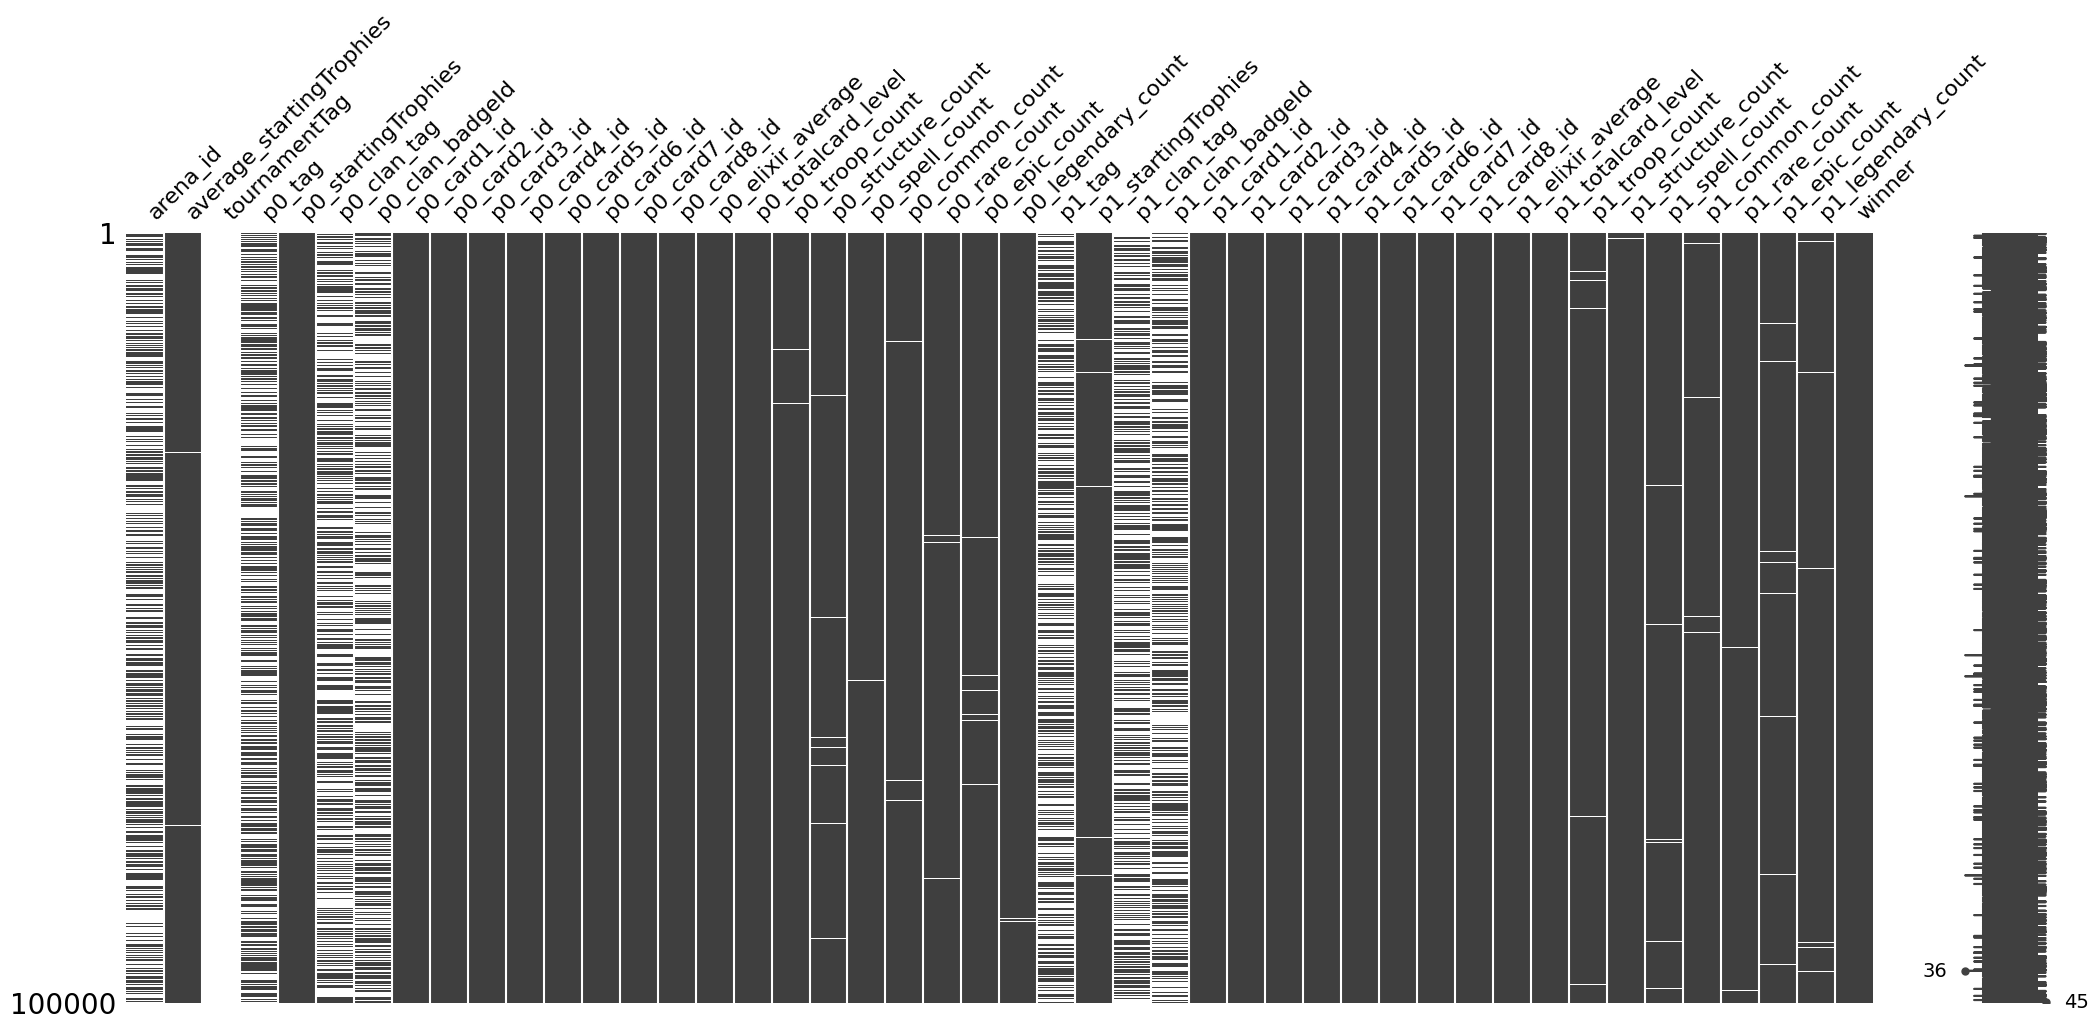

In [18]:
msno.matrix(df_corrupt.sample(100000))

## Save to csv

Save the final dataset, that I will use for the actual project

In [19]:
# save to csv
df_corrupt.to_csv('./data/ClashRoyaleDataset_corrupted.csv')